### Choosing data and creating train datasets

In [2]:
import numpy as np
import pandas as pd
import NegativeClassOptimization.config as config
import glob
from pathlib import Path
import re
import matplotlib.pyplot as plt
from itertools import combinations, permutations

In [3]:
from itertools import combinations, permutations

In [4]:
antigens = ['3VRL', '1NSN', '3RAJ', '5E94', '1H0D', '1WEJ', '1ADQ', '1FBI','2YPV', '1OB1']
comb = list(combinations(antigens, 2))
perm = list(permutations(antigens, 2))

### Investigating a dataset

In [5]:
path_div2class = 'full_data/divided2classes'
paths_ADQ = glob.glob(str(Path(config.DATA_BASE_PATH / path_div2class)) + '/*ADQ_*Analyses/*ADQ_*')

In [6]:
paths_ADQ_dict = dict()
ag_folder_names = []
for p in paths_ADQ:
    name = re.search('_[A-Z]_(.*)\.txt', p).group(1)
    ag_folder_names.append(name)
    paths_ADQ_dict[name] = p

In [7]:
ag_folder_names

['MascotteSlices',
 'HeroesSlices',
 'LooserExclusive',
 'SuperHeroesSlices',
 '500kNonMascotte',
 'MascotteExclusiveSlices',
 'Mascotte',
 'MascotteExclusive',
 'LooserExclusiveSlices',
 'superHeroes',
 'LooserSlices',
 'HeroesExclusive',
 'HeroesExclusiveSlices',
 'Heroes',
 'Looser']

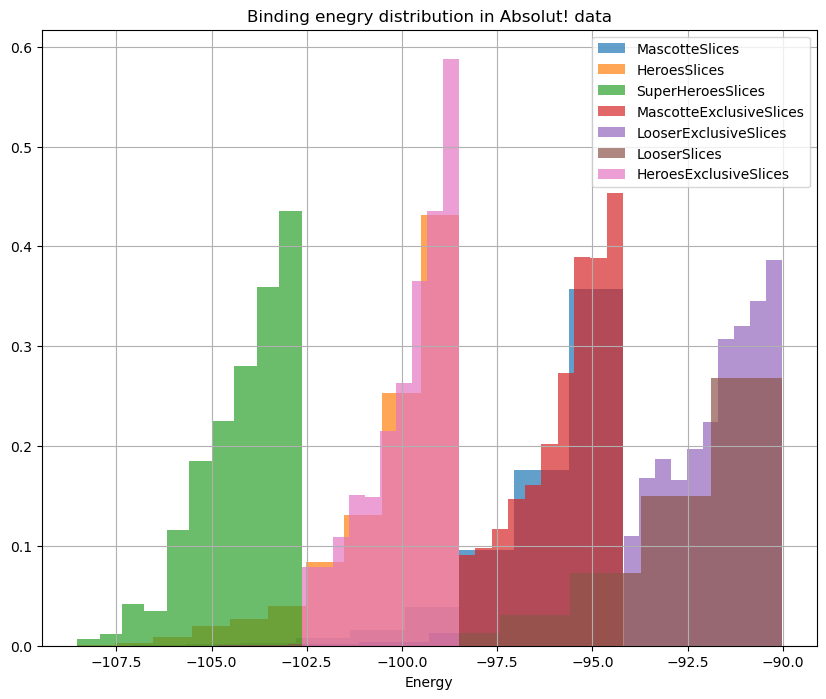

In [8]:
for name in ag_folder_names:
    if "Slices" in name:
        df_i = pd.read_csv(paths_ADQ_dict[name], sep='\t', header=[1])
        df_i.Energy.hist(density=True, label=name, alpha=0.7, figsize=(10,8))
        plt.legend()
        plt.xlabel('Energy')
        plt.title('Binding enegry distribution in Absolut! data')

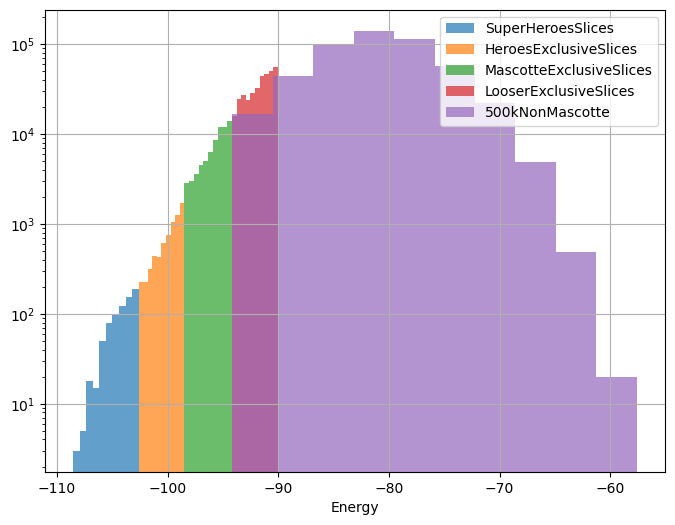

In [9]:
for name in ['SuperHeroesSlices','HeroesExclusiveSlices', 'MascotteExclusiveSlices', 'LooserExclusiveSlices', '500kNonMascotte']:
    df_i = pd.read_csv(paths_ADQ_dict[name], sep='\t', header=[1])
    df_i.Energy.hist(label=name, alpha=0.7, figsize=(8,6), log = True)
    plt.legend()
    plt.xlabel('Energy')

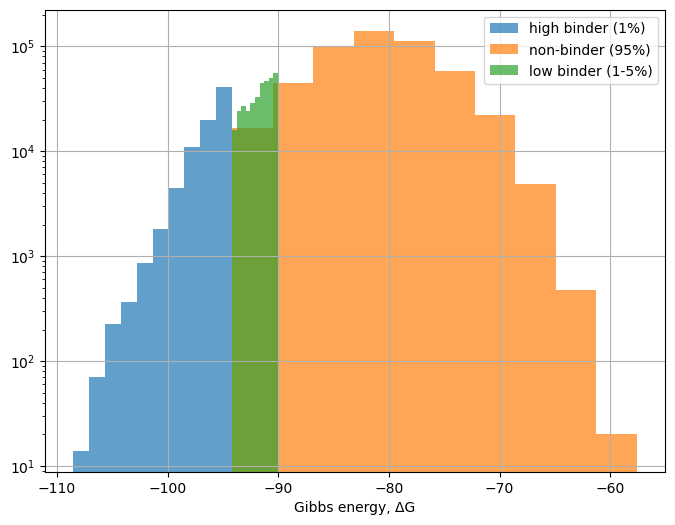

In [13]:
for name in ['MascotteSlices', '500kNonMascotte', 'LooserExclusiveSlices']:
    df_i = pd.read_csv(paths_ADQ_dict[name], sep='\t', header=[1])
    df_i.Energy.hist(label=name, alpha=0.7, figsize=(8,6), log = True)
plt.legend(["high binder (1%)", 'non-binder (95%)', 'low binder (1-5%)'], loc='upper right')
plt.xlabel('Gibbs energy, ΔG')
plt.savefig('./plots/energy_distribution.png')
plt.show()

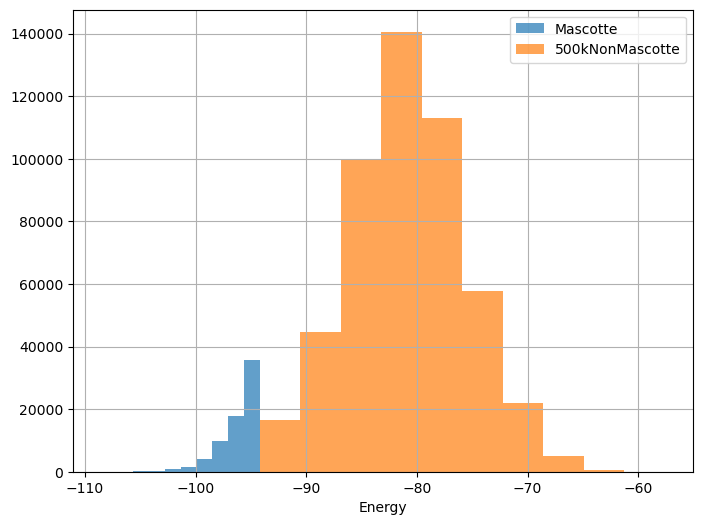

In [11]:
for name in ['Mascotte', '500kNonMascotte']:
    if "Slices" not in name:
        df_i = pd.read_csv(paths_ADQ_dict[name], sep='\t', header=[1])
        df_i.Energy.hist(label=name, alpha=0.7, figsize=(8,6))
        plt.legend()
        plt.xlabel('Energy')

I can use "Mascotte" and "500kNonMascotte" but I need to check how many affinity points I should have between them

### Selecting data for all antigens

In [1]:
#just to see difference in energy between binders and non-binders
non_binders_min = []
binders_max = []
for antigen in antigens:
    df_a_non_binder = pd.read_csv(glob.glob(str(Path(config.DATA_BASE_PATH / path_div2class)) + f'/*{antigen}*Analyses/*{antigen}_*_500kNonMascotte.txt')[0], sep='\t', header=[1])
    df_a_binder = pd.read_csv(glob.glob(str(Path(config.DATA_BASE_PATH / path_div2class)) + f'/*{antigen}*Analyses/*{antigen}_*_Mascotte.txt')[0], sep='\t', header=[1])
    lower = df_a_non_binder.Energy.min()
    non_binders_min.append(lower)
    upper = df_a_binder.Energy.max()
    binders_max.append(upper)

NameError: name 'antigens' is not defined

In [11]:
energy_difference = np.array(non_binders_min) - np.array(binders_max)

In [12]:
pd.DataFrame([antigens, binders_max, non_binders_min, energy_difference], index=['Antigen', 'binders_max', 'non_binders_min', 'energy_diffrence']).T

,Antigen,binders_max,non_binders_min,energy_diffrence
0,3VRL,-96.46,-96.45,0.01
1,1NSN,-89.99,-89.98,0.01
2,3RAJ,-100.3,-100.29,0.01
3,5E94,-96.31,-96.3,0.01
4,1H0D,-82.04,-82.03,0.01
5,1WEJ,-73.24,-73.23,0.01
6,1ADQ,-94.19,-94.18,0.01
7,1FBI,-89.99,-89.98,0.01
8,2YPV,-95.18,-95.17,0.01
9,1OB1,-92.52,-92.51,0.01


Deleting duplictes between antigen among high-binders. Creating intersection set and then deleting them from all binders

In [13]:
def mascotte_df(antigen): 
    """
    Return binders DataFrame
    """
    df_ag = pd.read_csv(glob.glob(str(Path(config.DATA_BASE_PATH / path_div2class)) + f'/*{antigen}*Analyses/*{antigen}_*_MascotteSlices.txt')[0], sep='\t', header=[1])
    df_ag.drop_duplicates(subset='Slide', inplace=True)
    n=df_ag.shape[0]
    df_ag['binder'] = [True]*n
    df_ag['Antigen'] = [antigen]*n
    df_ag = df_ag.astype({'Antigen': str})
    df_ag.to_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{antigen}_wo_dupl.tsv', sep='\t', index=False)
    return df_ag

In [14]:
#finding overlap
common_slides = set()
overlap_dict = dict()
for ag1, ag2 in comb:
    df_ag1 = mascotte_df(ag1)
    df_ag2 = mascotte_df(ag2)
    ag1_set = set(df_ag1.Slide)
    ag2_set = set(df_ag2.Slide)
    overlap = ag1_set.intersection(ag2_set)
    common_slides.update(overlap)
    overlap_dict[(ag1,ag2)] = len(overlap)

#dropping overlap
num_dropped_dict = dict()
dataset_sizes = dict()
for antigen in antigens:
    df_i = pd.read_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{antigen}_wo_dupl.tsv', sep='\t')
    df_i['drop'] = df_i['Slide'].isin(common_slides)
    num_dropped_dict[antigen] = df_i[df_i['drop']==False].shape[0]
    df_i = df_i[df_i['drop'] == False]
    dataset_sizes[antigen] = df_i.shape[0]
    df_i.to_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{antigen}_wo_dupl.tsv', sep='\t', index=False)
    

In [15]:
overlap_dict

{('3VRL', '1NSN'): 1908,
 ('3VRL', '3RAJ'): 6606,
 ('3VRL', '5E94'): 6057,
 ('3VRL', '1H0D'): 1270,
 ('3VRL', '1WEJ'): 5088,
 ('3VRL', '1ADQ'): 7526,
 ('3VRL', '1FBI'): 902,
 ('3VRL', '2YPV'): 1553,
 ('3VRL', '1OB1'): 2763,
 ('1NSN', '3RAJ'): 4162,
 ('1NSN', '5E94'): 4496,
 ('1NSN', '1H0D'): 1287,
 ('1NSN', '1WEJ'): 1902,
 ('1NSN', '1ADQ'): 2853,
 ('1NSN', '1FBI'): 1365,
 ('1NSN', '2YPV'): 789,
 ('1NSN', '1OB1'): 6086,
 ('3RAJ', '5E94'): 9892,
 ('3RAJ', '1H0D'): 3203,
 ('3RAJ', '1WEJ'): 6294,
 ('3RAJ', '1ADQ'): 5726,
 ('3RAJ', '1FBI'): 7635,
 ('3RAJ', '2YPV'): 4520,
 ('3RAJ', '1OB1'): 3382,
 ('5E94', '1H0D'): 3553,
 ('5E94', '1WEJ'): 7628,
 ('5E94', '1ADQ'): 7042,
 ('5E94', '1FBI'): 3071,
 ('5E94', '2YPV'): 2845,
 ('5E94', '1OB1'): 8641,
 ('1H0D', '1WEJ'): 876,
 ('1H0D', '1ADQ'): 1137,
 ('1H0D', '1FBI'): 806,
 ('1H0D', '2YPV'): 6090,
 ('1H0D', '1OB1'): 714,
 ('1WEJ', '1ADQ'): 4643,
 ('1WEJ', '1FBI'): 1953,
 ('1WEJ', '2YPV'): 1146,
 ('1WEJ', '1OB1'): 3428,
 ('1ADQ', '1FBI'): 2758,
 ('1A

In [16]:
num_dropped_dict

{'3VRL': 32388,
 '1NSN': 34857,
 '3RAJ': 24960,
 '5E94': 25289,
 '1H0D': 38836,
 '1WEJ': 27358,
 '1ADQ': 27646,
 '1FBI': 24520,
 '2YPV': 34598,
 '1OB1': 34323}

In [17]:
dataset_sizes

{'3VRL': 32388,
 '1NSN': 34857,
 '3RAJ': 24960,
 '5E94': 25289,
 '1H0D': 38836,
 '1WEJ': 27358,
 '1ADQ': 27646,
 '1FBI': 24520,
 '2YPV': 34598,
 '1OB1': 34323}

Divide to train and test

In [18]:
min(dataset_sizes.values())

24520

In [19]:
SMALLEST_DATASET_SIZE = 24500
TRAIN_RATIO = 0.7
TEST_RATIO = 0.3
RANDOM_STATE = 0

#### High-low affinity dataset

In [20]:
#new variant
for antigen in antigens:
    df_binder =  pd.read_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{antigen}_wo_dupl.tsv', sep='\t')
    df_binder = df_binder.sample(SMALLEST_DATASET_SIZE, random_state = RANDOM_STATE).reset_index(drop=True)
    df_binder.drop('drop',axis=1, inplace=True)
    train_size = int(SMALLEST_DATASET_SIZE*TRAIN_RATIO)
    test_size = int(SMALLEST_DATASET_SIZE*TEST_RATIO)
    df_binder['Train'] = [True]*train_size + [False]*test_size
    
    
    df_non_binder = pd.read_csv(glob.glob(str(Path(config.DATA_BASE_PATH / path_div2class)) + f'/*{antigen}*Analyses/*{antigen}_*_500kNonMascotte.txt')[0], sep='\t', header=[1])
    df_looser = pd.read_csv(glob.glob(str(Path(config.DATA_BASE_PATH / path_div2class)) + f'/*{antigen}*Analyses/*{antigen}_*_LooserExclusiveSlices.txt')[0], sep='\t', header=[1])
    energy_start = df_looser['Energy'].max()
    df_non_binder = df_non_binder[df_non_binder['Energy']>energy_start]
    df_non_binder.drop_duplicates(subset='Slide', inplace=True)
    df_non_binder = df_non_binder.sample(SMALLEST_DATASET_SIZE, random_state = RANDOM_STATE).reset_index(drop=True)
    n = df_non_binder.shape[0]
    df_non_binder['binder'] = [False]*n
    df_non_binder['Antigen'] = [antigen]*n
    df_non_binder = df_non_binder.astype({'Antigen': str})
    df_non_binder['Train'] = [True]*train_size + [False]*test_size
    
    df_full = pd.concat([df_binder, df_non_binder])
    df_full = df_full.sample(frac=1, random_state = RANDOM_STATE).reset_index(drop=True)
    df_full.rename(columns= {'ID_slide_Variant':'example_id'}, inplace=True)
    df_full.to_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{antigen}_high_95low.tsv', sep='\t', index=False)

In [21]:
for antigen in antigens:
    df_binder =  pd.read_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{antigen}_wo_dupl.tsv', sep='\t')
    df_binder = df_binder.sample(SMALLEST_DATASET_SIZE, random_state = RANDOM_STATE).reset_index(drop=True)
    df_binder.drop('drop',axis=1, inplace=True)
    train_size = int(SMALLEST_DATASET_SIZE*TRAIN_RATIO)
    test_size = int(SMALLEST_DATASET_SIZE*TEST_RATIO)
    df_binder['Train'] = [True]*train_size + [False]*test_size
    
    df_non_binder = pd.read_csv(glob.glob(str(Path(config.DATA_BASE_PATH / path_div2class)) + f'/*{antigen}*Analyses/*{antigen}_*_LooserExclusiveSlices.txt')[0], sep='\t', header=[1])
    df_non_binder.drop_duplicates(subset='Slide', inplace=True)
    df_non_binder = df_non_binder.sample(SMALLEST_DATASET_SIZE, random_state = RANDOM_STATE).reset_index(drop=True)
    n = df_non_binder.shape[0]
    df_non_binder['binder'] = [False]*n
    df_non_binder['Antigen'] = [antigen]*n
    df_non_binder = df_non_binder.astype({'Antigen': str})
    df_non_binder['Train'] = [True]*train_size + [False]*test_size
    
    df_full = pd.concat([df_binder, df_non_binder])
    df_full = df_full.sample(frac=1, random_state = RANDOM_STATE).reset_index(drop=True)
    df_full.rename(columns= {'ID_slide_Variant':'example_id'}, inplace=True)
    df_full.to_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{antigen}_high_looser.tsv', sep='\t', index=False)

Creating metadata file

In [22]:
def cretae_metadata(dataset_path, metadata_path):
    df_i =  pd.read_csv(dataset_path, sep='\t')
    df_train = df_i[df_i.Train == True][['example_id', 'Slide', 'binder', 'Antigen']]
    df_test = df_i[df_i.Train == False][['example_id', 'Slide', 'binder', 'Antigen']]
    df_train.to_csv(str(metadata_path) + '_train_metadata.csv', sep=',', index=False)
    df_test.to_csv(str(metadata_path) + '_test_metadata.csv', sep=',', index=False)

In [23]:
for antigen in antigens:
    dataset_path = config.DATA_BASE_PATH / f'full_data/high_low_concat/{antigen}_high_low.tsv'
    metadata_path = config.DATA_BASE_PATH /  f'full_data/high_low_concat/metadata/{antigen}_high_low'
    cretae_metadata(dataset_path, metadata_path)

### Datasets high vs high binders 

In [24]:
#common_slides = set()
for ag1, ag2 in comb:
    df_ag1 = pd.read_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{ag1}_high_low.tsv', sep='\t')
    df_ag2 = pd.read_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{ag2}_high_low.tsv', sep='\t')
    df_ag1 = df_ag1[df_ag1['binder'] == True]
    df_ag2 = df_ag2[df_ag2['binder'] == True]
    df_ag2['binder'] = False
    df_full = pd.concat([df_ag1, df_ag2])
    df_full = df_full.sample(frac=1, random_state = RANDOM_STATE).reset_index(drop=True)
    dataset_path = config.DATA_BASE_PATH / f'full_data/high_pairwise/{ag1}_{ag2}_highs.tsv'
    df_full.to_csv(dataset_path, sep='\t', index=False)
    metadata_path = config.DATA_BASE_PATH /  f'full_data/high_pairwise/metadata/{ag1}_{ag2}_highs'
    cretae_metadata(dataset_path, metadata_path)
    
    #reverse
    df_full['binder'] = ~df_full['binder']
    dataset_path = config.DATA_BASE_PATH / f'full_data/high_pairwise/{ag2}_{ag1}_highs.tsv'
    df_full.to_csv(dataset_path, sep='\t', index=False)
    metadata_path = config.DATA_BASE_PATH /  f'full_data/high_pairwise/metadata/{ag2}_{ag1}_highs'
    cretae_metadata(dataset_path, metadata_path)

return normal dataset, please:) maybe just concatenate test and train metadata file

### Dataset 1 vs all

In [25]:
IND_AG_DATA_SIZE = int(SMALLEST_DATASET_SIZE/9)

In [26]:
# change dataset sizes an set train test labels
antigen_dfs_list = []
for ag in antigens:
    df_ag = pd.read_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{ag}_high_low.tsv', sep='\t')
    df_ag = df_ag[df_ag['binder'] == True]
    df_ag_train = df_ag[df_ag['Train'] == True]
    df_ag_test = df_ag[df_ag['Train'] == False]
    df_ag_train = df_ag_train.sample(n = int(IND_AG_DATA_SIZE*TRAIN_RATIO), random_state = RANDOM_STATE)
    df_ag_test = df_ag_test.sample(n = int(IND_AG_DATA_SIZE*TEST_RATIO), random_state = RANDOM_STATE)
    df_ag = pd.concat([df_ag_train, df_ag_test])
    df_ag['binder'] = False
    antigen_dfs_list.append(df_ag)
mix_dataset_df = pd.concat(antigen_dfs_list)

In [27]:
for ag in antigens:
    df_negative = mix_dataset_df[mix_dataset_df['Antigen']  != ag]
    df_positive = pd.read_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{ag}_high_low.tsv', sep='\t')
    df_positive = df_positive[df_positive['binder'] == True]
    df_full = pd.concat([df_negative, df_positive]).sample(frac =1, random_state = RANDOM_STATE)
    dataset_path = config.DATA_BASE_PATH / f'full_data/1_vs_all/{ag}_vs_all.tsv'
    df_full.to_csv(dataset_path, sep='\t', index=False)
    metadata_path = config.DATA_BASE_PATH /  f'full_data/1_vs_all/metadata/{ag}_vs_all'
    cretae_metadata(dataset_path, metadata_path)

In [ ]:
#Debugging

In [ ]:
df_ex = pd.read_csv(config.DATA_BASE_PATH /  f'full_data/1_vs_all/metadata/1OB1_vs_all_train_metadata.csv')

In [ ]:
df_ex['binder'].value_counts()

In [ ]:
for ag in ['5E94']:
    print(mix_dataset_df.shape[0])
    df_negative = mix_dataset_df[mix_dataset_df['Antigen']  != 5e+94]
    print(df_negative.shape[0])
    df_positive = pd.read_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{ag}_highs.tsv', sep='\t')
    df_positive = df_positive[df_positive['binder'] == True]
    df_full = pd.concat([df_negative, df_positive]).sample(frac =1, random_state = RANDOM_STATE)
    dataset_path = config.DATA_BASE_PATH / f'full_data/1_vs_all/{ag}_vs_all.tsv'
    df_full.to_csv(dataset_path, sep='\t', index=False)
    metadata_path = config.DATA_BASE_PATH /  f'full_data/1_vs_all/metadata/{ag}_vs_all'
    cretae_metadata(dataset_path, metadata_path)

### Creating cross datasets for all possible pw_high testing

In [ ]:
permut = list(permutations(antigens, 2))

In [ ]:
for ag1, ag2 in permut:
    df_ag1 = pd.read_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{ag1}_wo_dupl.tsv', sep='\t')
    df_ag2 = pd.read_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{ag2}_wo_dupl.tsv', sep='\t')
    df_ag1 = df_ag1[df_ag1['binder'] == True]
    df_ag1 = df_ag1[df_ag1['Train'] == False]
    df_ag2 = df_ag2[df_ag2['binder'] == True]
    df_ag2 = df_ag2[df_ag2['Train'] == False]
    df_ag2['binder'] = False
    df_full = pd.concat([df_ag1, df_ag2])
    df_full = df_full.sample(frac=1, random_state = RANDOM_STATE).reset_index(drop=True)
    dataset_path = config.DATA_BASE_PATH / f'full_data/high_pairwise/test_tsv/cross_pw_high/{ag1}_{ag2}_test.tsv'
    df_full.to_csv(dataset_path, sep='\t', index=False)

## Evaluating train and test sizes

In [49]:
ag_train_test = dict()
ag_labels = dict()
for ag in antigens:
    df = pd.read_csv(f'../data/full_data/1_vs_all/{ag}_vs_all.tsv', sep='\t')
    ag_train_test[ag] = df['Train'].value_counts()
    ag_labels[ag] = df['binder'].value_counts()

In [50]:
ag_labels

{'3VRL': True     24500
 False    24489
 Name: binder, dtype: int64,
 '1NSN': True     24500
 False    24489
 Name: binder, dtype: int64,
 '3RAJ': True     24500
 False    24489
 Name: binder, dtype: int64,
 '5E94': False    27210
 True     24500
 Name: binder, dtype: int64,
 '1H0D': True     24500
 False    24489
 Name: binder, dtype: int64,
 '1WEJ': True     24500
 False    24489
 Name: binder, dtype: int64,
 '1ADQ': True     24500
 False    24489
 Name: binder, dtype: int64,
 '1FBI': True     24500
 False    24489
 Name: binder, dtype: int64,
 '2YPV': True     24500
 False    24489
 Name: binder, dtype: int64,
 '1OB1': True     24500
 False    24489
 Name: binder, dtype: int64}

In [42]:
ag_train_test

{'3VRL': True     34295
 False    14694
 Name: Train, dtype: int64,
 '1NSN': True     34295
 False    14694
 Name: Train, dtype: int64,
 '3RAJ': True     34295
 False    14694
 Name: Train, dtype: int64,
 '5E94': True     36200
 False    15510
 Name: Train, dtype: int64,
 '1H0D': True     34295
 False    14694
 Name: Train, dtype: int64,
 '1WEJ': True     34295
 False    14694
 Name: Train, dtype: int64,
 '1ADQ': True     34295
 False    14694
 Name: Train, dtype: int64,
 '1FBI': True     34295
 False    14694
 Name: Train, dtype: int64,
 '2YPV': True     34295
 False    14694
 Name: Train, dtype: int64,
 '1OB1': True     34295
 False    14694
 Name: Train, dtype: int64}

In [45]:
ag_high_low = dict()
for ag in antigens:
    df = pd.read_csv(f'../data/full_data/high_low_concat/{ag}_high_95low.tsv', sep='\t')
    ag_high_low[ag] = df['Train'].value_counts()

In [46]:
ag_high_low 

{'3VRL': True     34300
 False    14700
 Name: Train, dtype: int64,
 '1NSN': True     34300
 False    14700
 Name: Train, dtype: int64,
 '3RAJ': True     34300
 False    14700
 Name: Train, dtype: int64,
 '5E94': True     34300
 False    14700
 Name: Train, dtype: int64,
 '1H0D': True     34300
 False    14700
 Name: Train, dtype: int64,
 '1WEJ': True     34300
 False    14700
 Name: Train, dtype: int64,
 '1ADQ': True     34300
 False    14700
 Name: Train, dtype: int64,
 '1FBI': True     34300
 False    14700
 Name: Train, dtype: int64,
 '2YPV': True     34300
 False    14700
 Name: Train, dtype: int64,
 '1OB1': True     34300
 False    14700
 Name: Train, dtype: int64}

In [47]:
ag_high_looser = dict()
for ag in antigens:
    df = pd.read_csv(f'../data/full_data/high_low_concat/{ag}_high_looser.tsv', sep='\t')
    ag_high_looser[ag] = df['Train'].value_counts()

In [48]:
ag_high_looser

{'3VRL': True     34300
 False    14700
 Name: Train, dtype: int64,
 '1NSN': True     34300
 False    14700
 Name: Train, dtype: int64,
 '3RAJ': True     34300
 False    14700
 Name: Train, dtype: int64,
 '5E94': True     34300
 False    14700
 Name: Train, dtype: int64,
 '1H0D': True     34300
 False    14700
 Name: Train, dtype: int64,
 '1WEJ': True     34300
 False    14700
 Name: Train, dtype: int64,
 '1ADQ': True     34300
 False    14700
 Name: Train, dtype: int64,
 '1FBI': True     34300
 False    14700
 Name: Train, dtype: int64,
 '2YPV': True     34300
 False    14700
 Name: Train, dtype: int64,
 '1OB1': True     34300
 False    14700
 Name: Train, dtype: int64}

## Creating dataset mix of all

In [52]:
IND_ALL_DATA_SIZE = int(SMALLEST_DATASET_SIZE/10)

In [53]:
# change dataset sizes an set train test labels
antigen_dfs_list = []
for ag in antigens:
    df_ag = pd.read_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{ag}_high_low.tsv', sep='\t')
    #df_ag = df_ag[df_ag['binder'] == True]
    df_ag_train = df_ag[df_ag['Train'] == True]
    df_ag_test = df_ag[df_ag['Train'] == False]
    df_ag_train = df_ag_train.sample(n = int(IND_ALL_DATA_SIZE*TRAIN_RATIO), random_state = RANDOM_STATE)
    df_ag_test = df_ag_test.sample(n = int(IND_ALL_DATA_SIZE*TEST_RATIO), random_state = RANDOM_STATE)
    df_ag = pd.concat([df_ag_train, df_ag_test])
    #df_ag['binder'] = False
    antigen_dfs_list.append(df_ag)
all_dataset_df = pd.concat(antigen_dfs_list)

In [59]:
from tqdm.notebook import tqdm

In [60]:
for ag in tqdm(antigens, desc = 'antigens'):
    df_negative1 = all_dataset_df[all_dataset_df['Antigen']  != ag]
    df_negative2 = all_dataset_df[(all_dataset_df['Antigen']  == ag) & (all_dataset_df['binder']  == False)]
    df_negative = pd.concat([df_negative1, df_negative2])
    df_positive = pd.read_csv(config.DATA_BASE_PATH / f'full_data/high_low_concat/{ag}_high_low.tsv', sep='\t')
    df_positive = df_positive[df_positive['binder'] == True]
    df_full = pd.concat([df_negative, df_positive]).sample(frac =1, random_state = RANDOM_STATE)
    dataset_path = config.DATA_BASE_PATH / f'full_data/mix_all/{ag}_vs_mix_all.tsv'
    df_full.to_csv(dataset_path, sep='\t', index=False)
    metadata_path = config.DATA_BASE_PATH /  f'full_data/mix_all/metadata/{ag}_vs_mix_all'
    cretae_metadata(dataset_path, metadata_path)

antigens:   0%|          | 0/10 [00:00<?, ?it/s]